# Model quality assurance

In [1]:
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, mean_absolute_error, mean_squared_error
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex, to_rgb
import seaborn as sns
from adjustText import adjust_text
from assets.ac_visualization import plot_final_model_f1_scores, cell_network_graph_mqa
from assets.functions import create_multi_label, determine_overlap_celltypes_all

## Load data

In [2]:
# Load data
data_all = pd.read_pickle(pathlib.Path(r'data/processed_data/dataset_pred_complete.pkl'))

In [3]:
# load test data
data_test = pd.read_pickle(pathlib.Path(r'data/processed_data/dataset_pred_test.pkl'))

In [4]:
# list of all celltypes except Q*
celltypes_all = ['BP', 'CD4', 'CD8', 'Lympho', 'NKP',
                 'NKTP', 'T48NT', 'T48PT', 'T4P', 'T8P', 'TP']

# list of celltypes considered in the DDM
celltypes_ddm = ['Lympho', 'BP', 'NKP', 'TP','T4P', 'T8P']
parents_ddm = ['total', 'Lympho', 'Lympho', 'Lympho', 'Lympho', 'Lympho']

# list of column names for predicted events by the DDM
celltypes_pred = [f'pred_{celltype}' for celltype in celltypes_ddm]
parents_pred = ['total', 'pred_Lympho', 'pred_Lympho', 'pred_Lympho', 'pred_Lympho', 'pred_Lympho']

reported_ranges = pd.DataFrame({'Lympho': [18, 48], 'BP': [6, 23], 'NKP': [3, 22], 'TP': [56, 84],
                               'T4P': [31, 52], 'T8P': [18, 35]})
# reported_ranges = pd.DataFrame({'Lympho': [20, 44], 'BP': [7, 21], 'NKP': [4, 26], 'TP': [61, 84],
#                                'T4P': [32, 60], 'T8P': [23, 40]});
reported_ranges.index=['lower_bound', 'upper_bound']
reported_ranges = reported_ranges.T

In [5]:
categories = ["all events", "Lympho", 'BP', 'NKP', 'TP', 'T4P', 'T8P', 'NKTP']

viridis = plt.get_cmap('viridis')
vals = np.linspace(0, 1, len(categories))
[(val, to_hex(viridis(val))) for val in vals]
semi_viridis_hex_colors = [to_hex(viridis(val)) for val in vals]
# # Create a color dictionary
color_dict_hex = {category: i for  category, i  in zip(categories, semi_viridis_hex_colors)}

# Add new entries
color_dict_hex['NKT4P'] = '#fde725'
color_dict_hex['NKT8P'] = '#fde725'
color_dict_hex['BPNKP'] = '#ff0000'

In [6]:
categories = ["all events", "Lympho", 'BP', 'NKP', 'TP', 'T4P', 'T8P', 'NKTP']

viridis = plt.get_cmap('viridis')
vals = np.linspace(0, 1, len(categories))
[(val, to_rgb(viridis(val))) for val in vals]
semi_viridis_hex_colors = [to_rgb(viridis(val)) for val in vals]

# Create a color dictionary
color_dict_rgb = {category: i for  category, i  in zip(categories, semi_viridis_hex_colors)}

# Add new entries
color_dict_rgb['NKT4P'] = to_rgb('#fde725')
color_dict_rgb['NKT8P'] = to_rgb('#fde725')
color_dict_rgb['BPNKP'] = to_rgb('#ff0000')

In [7]:
plt.rc('figure', dpi=300)

## Evidence to argue MQC1

In [8]:
f1_scores_model = pd.read_pickle(r'data/processed_data/f1_scores_model.pkl')

In [9]:
f1_scores_model[50:].median()


Lympho    0.984588
BP        0.980483
NKP       0.938345
TP        0.994750
T4P       0.988926
T8P       0.995920
dtype: float64

In [10]:
f1_scores_model[50:].min()


Lympho    0.968357
BP        0.887420
NKP       0.699402
TP        0.966881
T4P       0.978262
T8P       0.937302
dtype: float64

In [16]:
f1_scores_model[50:].sort_values(by='NKP')

,Lympho,BP,NKP,TP,T4P,T8P
86,0.975098,0.974439,0.699402,0.991883,0.987143,0.995711
54,0.993364,0.978887,0.735294,0.995726,0.993555,0.994765
75,0.977668,0.989614,0.848077,0.994874,0.988253,0.996795
85,0.989855,0.991700,0.848287,0.996672,0.992604,0.995861
93,0.981455,0.982485,0.855692,0.995259,0.985457,0.998080
88,0.978870,0.982838,0.874023,0.994044,0.990461,0.993777
76,0.968357,0.887420,0.875203,0.989674,0.988119,0.993291
50,0.994626,0.991905,0.877477,0.997759,0.994912,0.997843
95,0.981122,0.973021,0.879250,0.994312,0.987934,0.992945
91,0.981365,0.964397,0.891144,0.994470,0.988051,0.996458


C:\Users\georg.popp\AppData\Local\Temp\ipykernel_26168\3310602507.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y='Class', x='F1 Score', data=long_df, palette=palette,


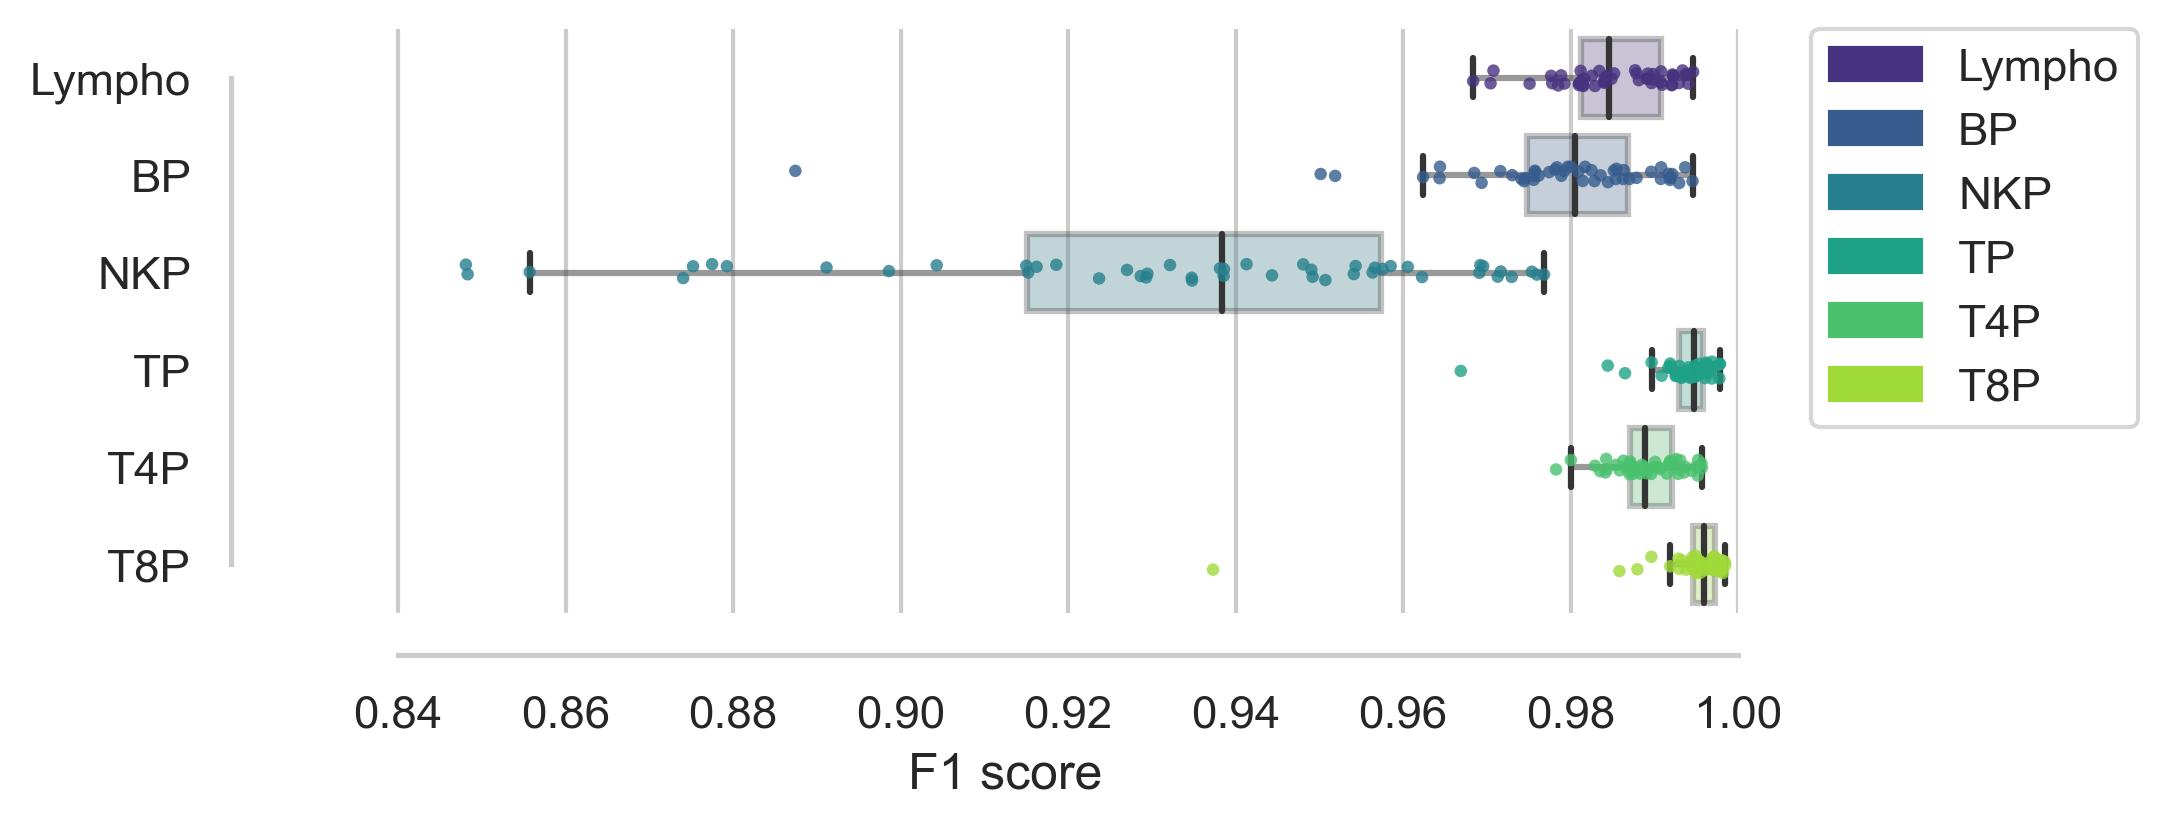

In [27]:
plot_final_model_f1_scores(f1_scores_model[50:], color_dict_rgb, save=False, loc='')

For all cell types, the median F1 scores within the test set are > 0.938345. F1 scores vary between cell types. The lowest F1 score was found for NK cells at 0.699402. 

Pleas note, that the limits of x axis (F1 score) is limited to the range [0.825, 1].

**Evidence**	<br>
1)	We generated a joint frequency matrix of all event cell types as predicted by the model. 



In [28]:
# generate joint frequency matric
determine_overlap_celltypes_all(data_test, celltypes_pred)

,pred_Lympho,pred_BP,pred_NKP,pred_TP,pred_T4P,pred_T8P
pred_Lympho,883419,113441,132230,623463,385336,187360
pred_BP,113441,113441,0,0,0,0
pred_NKP,132230,0,132230,93,7,0
pred_TP,623463,0,93,623463,385336,187360
pred_T4P,385336,0,7,385336,385336,0
pred_T8P,187360,0,0,187360,0,187360


**Conclusion**<br>
There are no predicted cells with inconsistent cell type combinations.


**Evidence** <br>
2)	We generated a list of unique cell type combinations based on the model predictions. All predicted cells have a consistent immune cell hierarchy.

In [14]:
# use a unique class map with expected label combinations (ref. immune cell hierarchy) and check if only those occur
# https://www.researchgate.net/figure/Lineage-tree-representation-of-cells-of-the-immune-system-Immune-cells-are-derived-from_fig1_335329658
# unique_class_map = {'0-0-0-0-0-0': 'None',
#                     '1-0-0-1-1-0': 'T4P',
#                     '1-1-0-0-0-0': 'BP',
#                     '1-0-1-0-0-0': 'NKP',
#                     '1-0-0-1-0-1': 'T8P',
#                     '1-0-0-1-0-0': 'TP',
#                     '1-0-1-1-1-0': 'NKT4P',
#                     '1-0-0-0-0-0': 'Lympho',
#                     '1-1-1-0-0-0': 'BPNKP',
#                     '1-0-1-1-0-0': 'NKTP',
#                     '1-0-1-1-0-1': 'NKT8P'}
unique_pred_labels = create_multi_label(data_test[celltypes_pred])

c:\Programming\aicontrol\PUBLIC_aicontrol\assets\functions.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'unique_class'] = df.astype(str).\


In [15]:
np.unique(unique_pred_labels)

array(['BP', 'Lympho', 'NKP', 'NKT4P', 'NKTP', 'None', 'T4P', 'T8P', 'TP'],
      dtype='<U6')

**Conclusion** <br>
There are no predicted cells with an inconsistent immune cell hierarchy.

In [29]:
# use number of predicted cell types scaled (*2) to visualize cell network
node_data = {'all events': 3440490*2 , 'Lympho': 883419*2, 'BP': 113441*2, 
            'NKP': 132230*2, 'TP': 623463*2, 'T4P': 385336*2, 'T8P': 187360*2,
            'NKTP': 93*2, 'NKT4P': 7*2}

# currently required for the cell_network_graph_mqa function
color_dict_hex_f = {'all events': '#440154',
                    'Lympho': '#46327e',
                    'BP': '#365c8d',
                    'NKP': '#277f8e',
                    'TP': '#1fa187',
                    'T4P': '#4ac16d',
                    'T8P': '#a0da39',
                    'NKTP': '#fde725',
                    'NKT4P': '#fde725'}

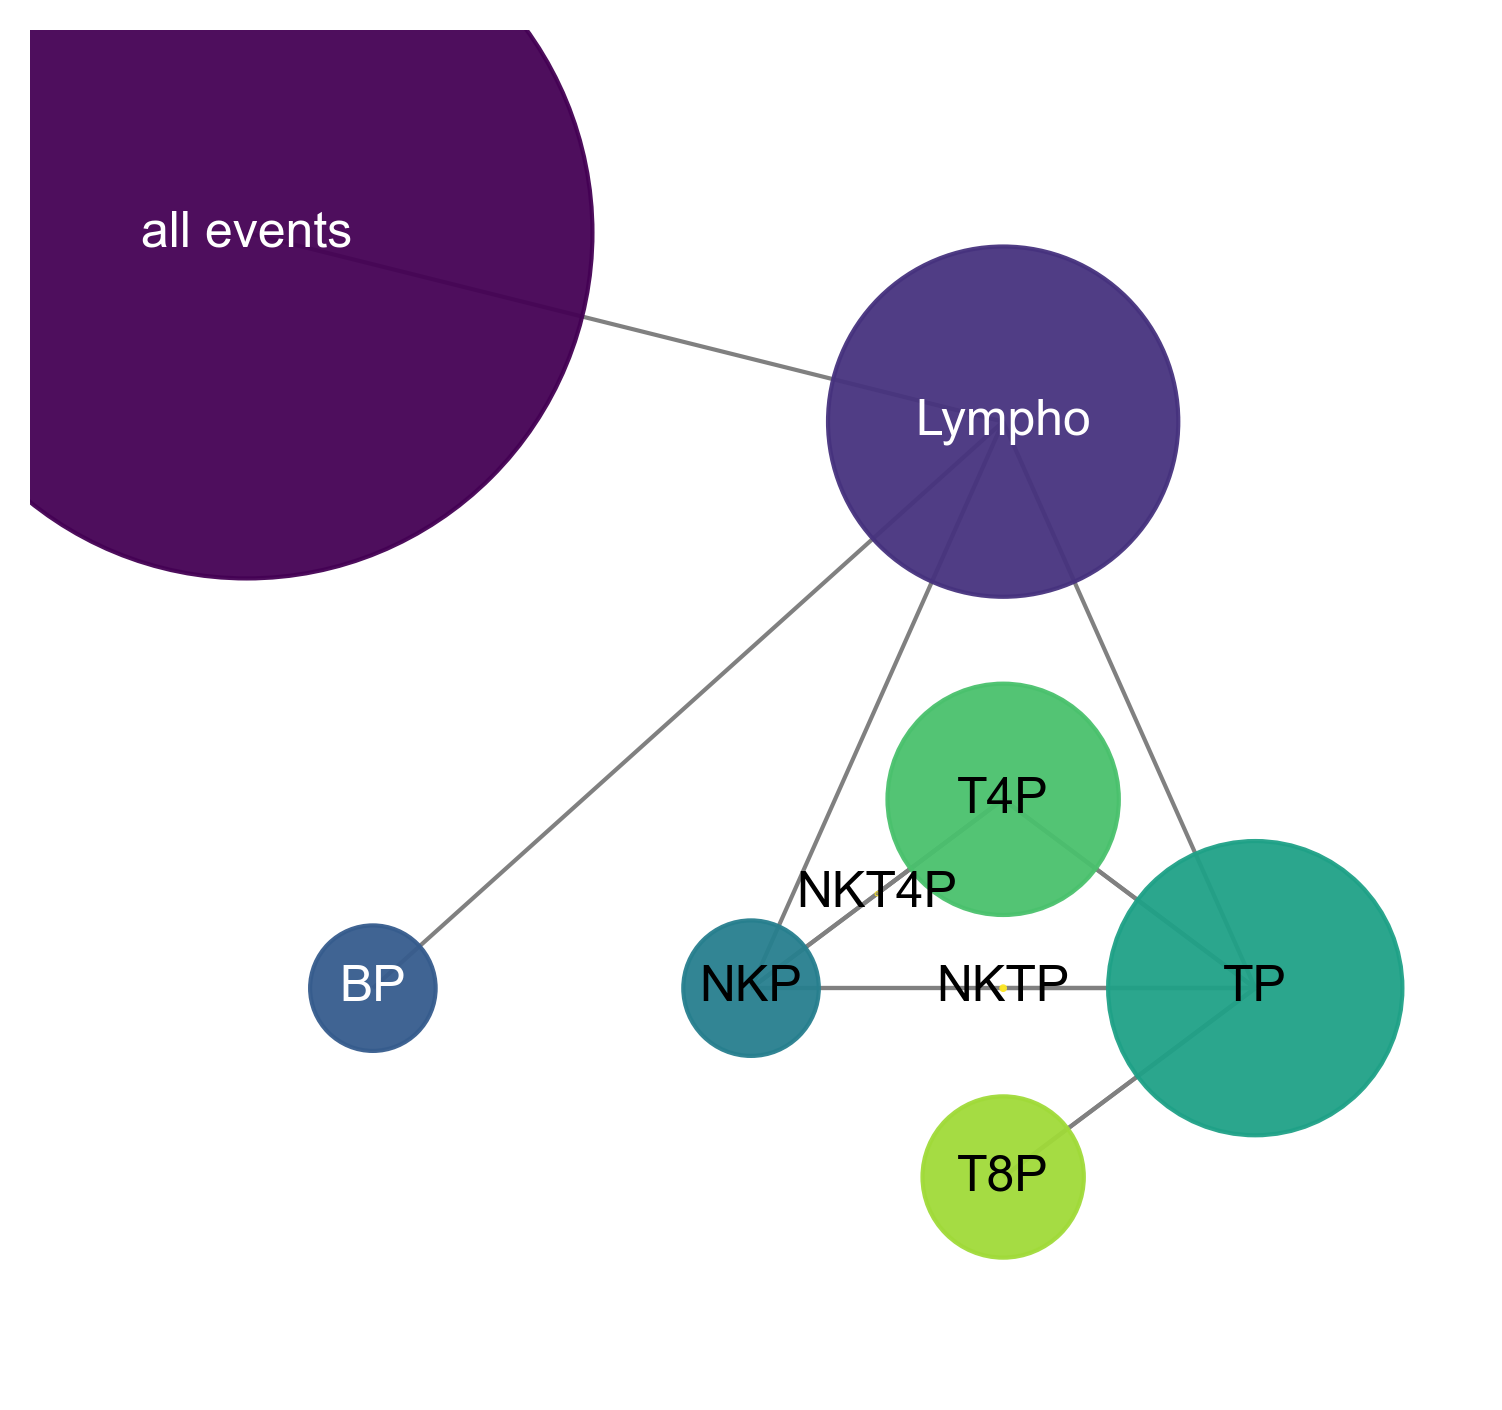

In [17]:
cell_network_graph_mqa(node_data=node_data, color_dict=color_dict_hex_f)

## Evidence to argue MQC2

**Evidence** <br>
The discrepancy between the model and expert 1 (ground truth) is quantified as mean absolute error (MAE) and root mean square error (RMSE) of cell ratios across the test set (50 samples). <br>
We compared the MAEs and RMSEs with the MAE and RMSE targets derived from the comparison of two experts (model benchmark). The model missed the MAE and RMSE targets for lymphocytes, B cells, NK cells and T cells. The model reached the MAE and TMSE targets for T helper cells and cytotoxic T cells. 


In [32]:
summed_expert1 = pd.read_pickle(pathlib.Path(r'data/experts_sums/expert1_summed.pkl'))
summed_model = pd.read_pickle(pathlib.Path(r'data/processed_data/model_summed.pkl'))
# rename columns for easier data handling
summed_model.columns = summed_expert1.columns
# load quantitative performance target from DQC6
performance_target = pd.read_pickle(pathlib.Path(r'data/processed_data/performance_target.pkl'))

In [33]:
mae_model = {}
rmse_model = {}

for celltype, parent in zip(celltypes_ddm, parents_ddm):
    
    expert1 = np.array(summed_expert1.loc['050':][celltype]/summed_expert1.loc['050':][parent])*100  # ground truth
    model = np.array(summed_model.loc['050':][celltype]/summed_model.loc['050':][parent])*100  # model predictions

    # calculate MAE
    mae_model_celltype = mean_absolute_error(expert1, model)
    mae_model[celltype] = mae_model_celltype
    # calculate RMSE
    rmse_model_celltype = np.sqrt(mean_squared_error(expert1, model))
    rmse_model[celltype] = rmse_model_celltype

    print(f"{celltype}\n MAE  model: {mae_model_celltype}\n RMSE model: {rmse_model_celltype}")

Lympho
 MAE  model: 0.47086577521557627
 RMSE model: 0.5956221807246284
BP
 MAE  model: 0.22273906102894056
 RMSE model: 0.38967107156172004
NKP
 MAE  model: 1.3501418620070962
 RMSE model: 2.0623540164121774
TP
 MAE  model: 1.0227612095201437
 RMSE model: 1.2537686356889128
T4P
 MAE  model: 0.32485072553818517
 RMSE model: 0.5297801068097414
T8P
 MAE  model: 0.36880697761062936
 RMSE model: 0.5118162421222527


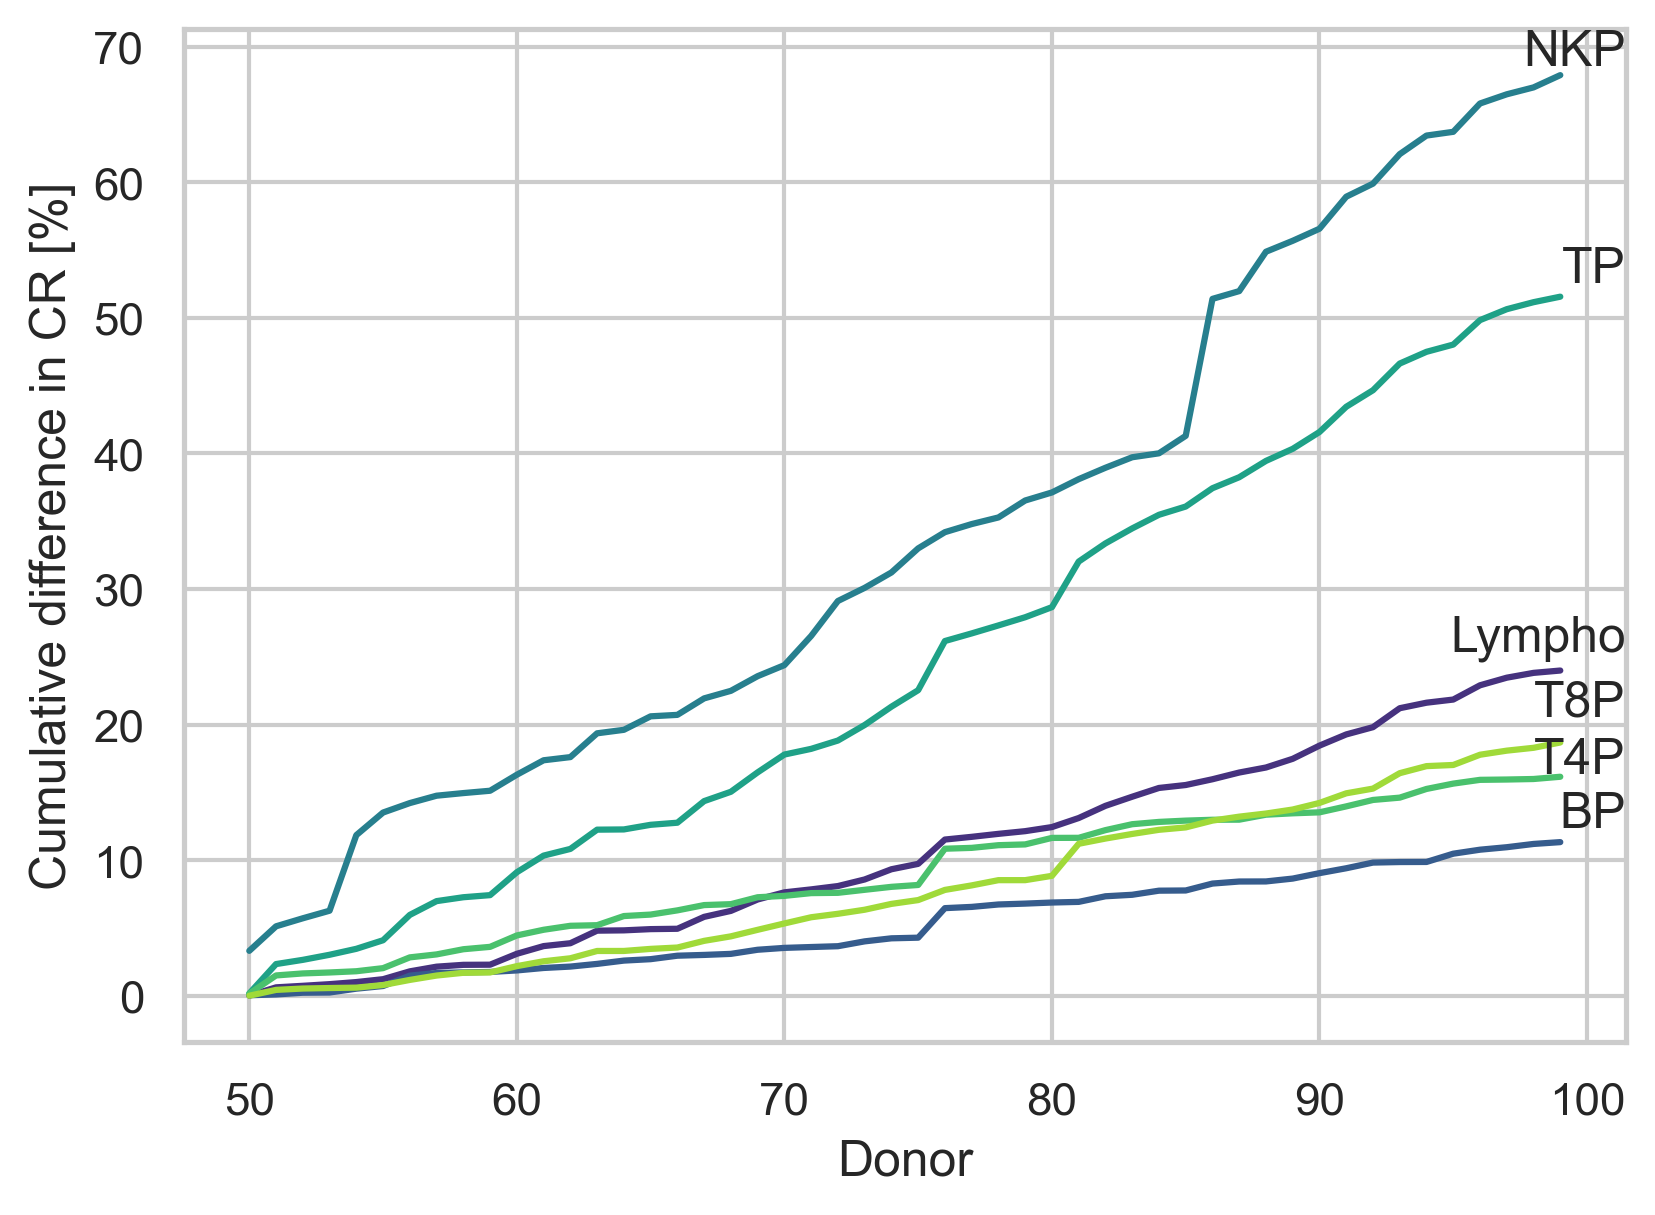

In [35]:
expert1 = np.array(summed_expert1[celltypes_ddm]/summed_expert1[parents_ddm].values)*100  # ground truth
model = np.array(summed_model[celltypes_ddm]/summed_model[parents_ddm].values)*100  # model predictions
abs_diff_test = pd.DataFrame(np.abs(expert1-model), columns=celltypes_ddm).loc[50:]
cumulative_sums = abs_diff_test.cumsum()

# Plot
plt.figure(figsize=(8.27/2*1.5, 11.69/3*1.5/2*1.5))
texts = []
for column in cumulative_sums.columns:
    plt.plot(cumulative_sums.index, cumulative_sums[column], label=column, color=color_dict_rgb.get(column))
    texts.append(plt.text(cumulative_sums.index[-1], cumulative_sums[column].iloc[-1], column))

adjust_text(texts)  # adjust text to minimize overlaps
plt.xlabel('Donor')
plt.ylabel('Cumulative difference in CR [%]')
# plt.legend()
plt.show()

In [36]:
# prepare data for table
error_target = np.round(performance_target.loc[['MAE', 'RMSE']], 2)
error_target.index = ['MAE target [CR in %]', 'RMSE target [CR in %]']
error_comparison = pd.concat([error_target, np.round(pd.DataFrame(mae_model.values(), index=mae_model.keys(), columns=['MAE model [CR in %]']).T, 2),
 np.round((pd.DataFrame(rmse_model.values(), index=rmse_model.keys(), columns=['RMSE model [CR in %]']).T), 2)])
error_comparison

,Lympho,BP,NKP,TP,T4P,T8P
MAE target [CR in %],0.27,0.11,0.82,0.65,0.82,0.68
RMSE target [CR in %],0.38,0.16,1.41,0.97,1.56,0.95
MAE model [CR in %],0.47,0.22,1.35,1.02,0.32,0.37
RMSE model [CR in %],0.60,0.39,2.06,1.25,0.53,0.51


**Conclusion** <br>
The quality of model gating is inconsistent when benchmarked against inter-laboratory variation observed in manual gating. 

## Evidence to argue MQC3

**Evidence**<br>
The decisions are considered matched, if both cell ratios fall within or outside the standard range. The discrepancy between model and expert 1 (ground truth) is quantified as the number of mismatched decisions. The model missed the decision target for lymphocytes. The model reached the decision targets for B cells, NK cells, T cells, T helper cells and cytotoxic T cells.

In [37]:
# function to compare
def compare_to_standard_range(summed_events_df, celltype, parent, lower_bound, upper_bound):
    true_value = summed_events_df.loc[:, celltype]/summed_events_df.loc[:, parent]
    # number of events classified as the celltype is outside the reference range
    return (true_value >= lower_bound) & (true_value <= upper_bound)

In [38]:
health_status_model = pd.DataFrame()
for celltype, parent in zip(celltypes_ddm, parents_ddm):
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']/100
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']/100
    health_status_model.loc[:, celltype] = compare_to_standard_range(
        summed_model, celltype, parent, lower_bound, upper_bound)

In [39]:
health_status_expert1 = pd.DataFrame()
for celltype, parent in zip(celltypes_ddm, parents_ddm):
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']/100
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']/100
    health_status_expert1.loc[:, celltype] = compare_to_standard_range(
        summed_expert1, celltype, parent, lower_bound, upper_bound)

In [40]:
deviation_model_decision = multilabel_confusion_matrix(health_status_expert1.loc['051':].astype('int'), 
                                                         health_status_model.loc['051':].astype('int'))

In [41]:
decision_target = performance_target.loc[['FP', 'FN']]
decision_target.index = ['FP target', 'FN target']
decision_comparison_list = []
for i in range(6):
    tn, fp, fn, tp = deviation_model_decision[i].ravel()
    decision_comparison_list.append([fp, fn])
decision_comparison = pd.DataFrame(decision_comparison_list, 
                                                 columns=["FP model", "FN model"], index=celltypes_ddm).T
decision_comparison = pd.concat([decision_target, decision_comparison]).astype(int)
decision_comparison = pd.concat([decision_comparison, 
                                 pd.DataFrame(decision_comparison.loc['FP target']+decision_comparison.loc['FN target'],
                                              columns=['Target total decision mismatch']).T,
                                pd.DataFrame(decision_comparison.loc['FP model']+decision_comparison.loc['FN model'],
                                             columns=['Model total decision mismatch']).T])

In [42]:
decision_comparison

,Lympho,BP,NKP,TP,T4P,T8P
FP target,0,0,2,0,0,0
FN target,0,0,0,0,0,1
FP model,0,0,2,0,0,1
FN model,1,0,0,0,0,0
Target total decision mismatch,0,0,2,0,0,1
Model total decision mismatch,1,0,2,0,0,1


**Conclusion**<br>
The quality of model decisions is inconsistent when benchmarked against inter-laboratory variation observed at the decision-level. 

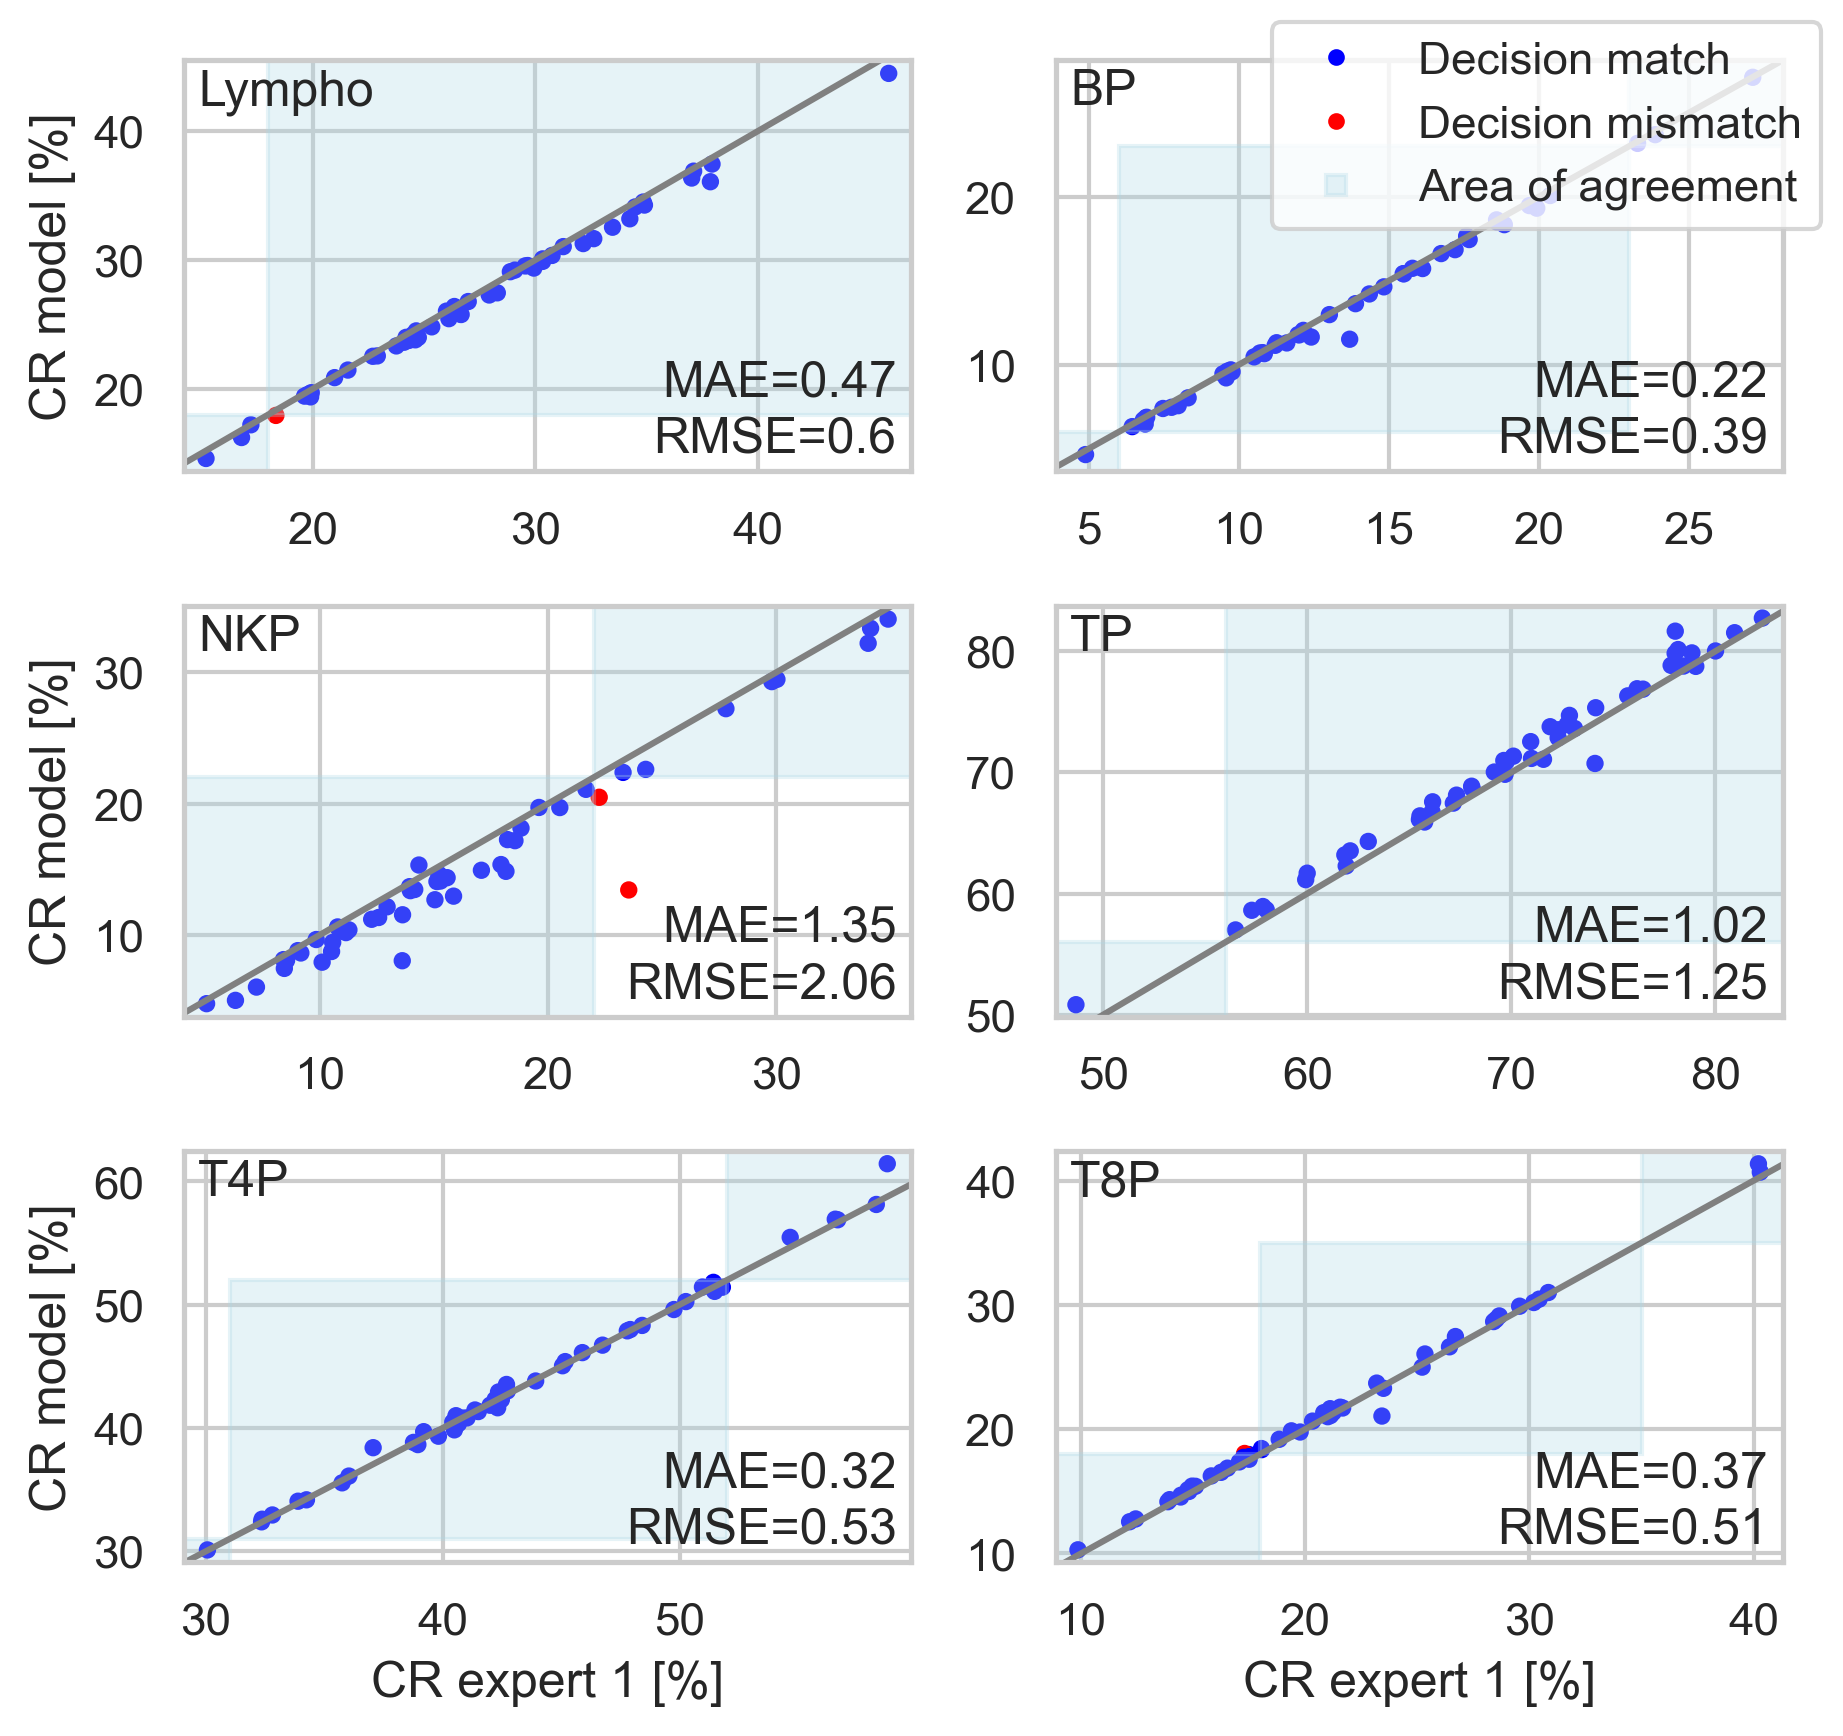

In [43]:
import matplotlib.patches as patches
import seaborn as sns
from assets.functions import create_scatter

# Create a figure with 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(8.27/2*1.5, 11.69/3*1.5))
sns.set_theme(style='whitegrid')

# Flatten the axs array for easy iteration
axs = axs.flatten()

for idx, (ax, (celltype, parent)) in enumerate(zip(axs, zip(celltypes_ddm, parents_ddm))):
    fig_data = create_scatter(celltype=celltype, parent=parent, summed_expert1=summed_expert1.loc['051':], 
                         summed_expert2=summed_model.loc['051':])
    fig_data = fig_data*100
    # Get the lower and upper bounds
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']

    # Create a mask for points outside the rectangles
    mask1 = (fig_data['Gating_expert1'] < lower_bound) | (fig_data['Gating_expert1'] > upper_bound) | (fig_data['Gating_expert2'] < lower_bound) | (fig_data['Gating_expert2'] > upper_bound)
    mask2 = (fig_data['Gating_expert1'] < 0) | (fig_data['Gating_expert1'] > lower_bound) | (fig_data['Gating_expert2'] < 0) | (fig_data['Gating_expert2'] > lower_bound)
    mask3 = (fig_data['Gating_expert1'] < upper_bound) | (fig_data['Gating_expert1'] > 100) | (fig_data['Gating_expert2'] < upper_bound) | (fig_data['Gating_expert2'] > 100)

    # Combine the masks
    mask = mask1 & mask2 & mask3

    # Color points based on the mask
    colors = np.where(mask, 'red', 'blue')

    ax.scatter(x=fig_data['Gating_expert1'], y=fig_data['Gating_expert2'], s=10, c=colors)
    line1 = mlines.Line2D([0, 100], [0, 100], color='gray')
    ax.add_line(line1)

    # Create a rectangle from the lower and upper bounds
    rectangle = patches.Rectangle((lower_bound, lower_bound), upper_bound-lower_bound, upper_bound-lower_bound, color='lightblue', alpha=0.3)

    agreement_area_not_healthy_lower = patches.Rectangle((0, 0), 
                                                        lower_bound, 
                                                        lower_bound, 
                                                        color='lightblue', alpha=0.3)
    ax.add_patch(agreement_area_not_healthy_lower)

    agreement_area_not_healthy_upper = patches.Rectangle((upper_bound, upper_bound), 
                                                        100 - upper_bound, 
                                                        100 - upper_bound, 
                                                        color='lightblue', alpha=0.3)
    ax.add_patch(agreement_area_not_healthy_upper)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Rescale the x and y axes to the original scatter plot
    ax.set_xlim([fig_data['Gating_expert1'].min()-1, fig_data['Gating_expert1'].max()+1])
    ax.set_ylim([fig_data['Gating_expert2'].min()-1, fig_data['Gating_expert2'].max()+1])

    # Add labels and title
    if idx in [4, 5]:  # plots 5 and 6
        ax.set_xlabel('CR expert 1 [%]')
    if idx in [0, 2, 4]:  # plots 1, 3, 5
        ax.set_ylabel('CR model [%]')
    # Set title in the upper left corner
    ax.text(0.02, 0.98, celltype, transform=ax.transAxes, verticalalignment='top')
    ax.text(0.98, 0.16, 'MAE='+str(np.round(mae_model[celltype],2)), transform=ax.transAxes, 
            verticalalignment='bottom', ha='right')
    ax.text(0.98, 0.02, 'RMSE='+str(np.round(rmse_model[celltype],2)), transform=ax.transAxes, 
            verticalalignment='bottom', ha='right')

    # Show grid lines
    ax.grid(True)

# Create a Line2D for each color
blue_line = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=3, label='Decision match')
red_line = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=3, label='Decision mismatch')
green_line = mlines.Line2D([], [], color='lightblue', alpha=0.3, marker='s', linestyle='None', markersize=5, label='Area of agreement')

# Add the legend to the figure
fig.legend(handles=[blue_line, red_line, green_line], loc='upper right', facecolor='white', framealpha=.8)
plt.tight_layout()
plt.show()


## Evidence to argue MQC4

**Evidence**	<br>
Encapsulate the model with an uncertainty wrapper and indicate the uncertainty of each event classification in scatter plots.

In [44]:
# load libraries and functions
from assets.hierarchy import get_hierarchy_lookup
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.colors as mcolors

In [46]:
# load results from uncertainty estimation
unc_data = pd.read_pickle(pathlib.Path(r'data/uncertainty_data/uncertainty_dict.pkl'))

In [47]:
# select uncertainty
unc_data = pd.concat([unc_data[key][[col for col in unc_data[key].columns if col.endswith('_basic')]] for key in unc_data.keys()], axis=1)
unc_data.columns = unc_data.columns.map(lambda x: x.replace('uw_', 'unc_') if x.startswith('uw_') else x)
unc_data.columns = unc_data.columns.map(lambda x: x.replace('_basic', '') if x.endswith('_basic') else x)


In [48]:
# get list of uncertainty columns
unc_cols = [col for col in unc_data.columns if 'unc' in col]

In [50]:
# load gate settings per patient from expert 1
gating_df = pd.read_pickle(pathlib.Path(r'data\processed_data\manual_gating_expert1.pkl'))

In [51]:
data_all = data_all.join(unc_data[unc_cols])

In [52]:
def create_colormap(celltype, color_dict):
    color = color_dict[celltype]
    cmap = mcolors.LinearSegmentedColormap.from_list(celltype, ['white', color])
    return cmap

In [53]:
def plot_uncertainty_gating(event_df: pd.DataFrame, gatings, celltype:str, celltype2:str, 
                            sample_number:int, show_gates= True,
                            gate_number:int = None, view_window=False,
                            xlim=[0,2], ylim=[0,1], linthx=1000, linthy=1000,
                            hierarchy=pd.DataFrame()):
    sample_number = str(sample_number).zfill(3)
    
    # select events for the sample number (i.e. patient ID)
    events_of_sample = event_df.loc[event_df.file == sample_number].copy()
    
    # get relevant channels/markers for this cell type
    hierarchy_lookup = hierarchy

    marker_x = hierarchy_lookup.loc[celltype, 'marker_x']
    marker_y = hierarchy_lookup.loc[celltype, 'marker_y']  
    parent = hierarchy_lookup.loc[celltype, 'parent']
    
    
    # get gates (if available; Lympho has no linear gates)
    if show_gates and celltype != 'Lympho':
        
        if gate_number is None:
            # if no gate number (e.g. from another patient) is specified, then take the gatings from the patient to plot
            gate_number = sample_number
            
        gate_x_q12 = gatings.loc[gate_number, f'{celltype}_{marker_x}_q12']
        gate_x_q34 = gatings.loc[gate_number, f'{celltype}_{marker_x}_q34']
        gate_y_q13 = gatings.loc[gate_number, f'{celltype}_{marker_y}_q13']
        gate_y_q24 = gatings.loc[gate_number, f'{celltype}_{marker_y}_q24']
        
    if celltype=='CD4':
        celltype = 'T4P'
    elif celltype=='CD8':
        celltype = 'T8P'
    
    if celltype2=='CD4':
        celltype2 = 'T4P'
    elif celltype2=='CD8':
        celltype2 = 'T8P'

    if celltype=='T48PT':
        celltype = 'T4P'
        celltype2 = 'T8P'
        parent = 'TP'   

    if celltype=='CD4xDRx38':
        celltype = 'T4P'
        parent = 'T4P'
    elif celltype=='CD8xDRx38':
        celltype = 'T8P' 
        parent='T8P'

    # sort the events by their associated uncertainty, s.t. events with higher uncertainties are plotted above the others
    events_of_sample.sort_values(by=f'unc_{celltype}', inplace=True)
    positive_events = events_of_sample.loc[(events_of_sample[f'pred_{celltype}'] == 1)]

    if celltype == 'Lympho':
        negative_events = events_of_sample.loc[(events_of_sample[f'pred_{celltype}'] == 0)]
    elif celltype2 in celltypes_ddm:
        events_of_sample.sort_values(by=f'unc_{celltype2}', inplace=True)
        positive_events2 = events_of_sample.loc[(events_of_sample[f'pred_{celltype2}'] == 1)]
        events_of_sample.sort_values(by=f'unc_{parent}', inplace=True)
        negative_events = events_of_sample.loc[(events_of_sample[f'pred_{celltype}'] == 0) & (events_of_sample[parent] == 1)
                                            & (events_of_sample[f'pred_{celltype2}'] == 0)]
    else:
        events_of_sample.sort_values(by=f'unc_{parent}', inplace=True)
        negative_events = events_of_sample.loc[(events_of_sample[f'pred_{celltype}'] == 0) & (events_of_sample[parent] == 1)]
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=300)
    
    # cmap_pos = plt.get_cmap('Blues')
    norm = mcolors.Normalize(vmin=-0.3, vmax=1)
    if celltype2 in celltypes_ddm:
        cmap2 = create_colormap(celltype2, color_dict_hex)
        scat_pos2 = ax.scatter(positive_events2[marker_x], positive_events2[marker_y], c=positive_events2['unc_' + celltype2], 
                cmap=cmap2, norm=norm, s=0.3, alpha=1)
    
    if celltype == 'Lympho':
        cmap1 = create_colormap(celltype, color_dict_hex)
        scat_pos = ax.scatter(positive_events[marker_x], positive_events[marker_y], c=positive_events['unc_' + celltype], 
                cmap=cmap1, norm=norm, s=0.3, alpha=1)
    elif celltype in celltypes_ddm:
        cmap1 = create_colormap(celltype, color_dict_hex)
        scat_pos = ax.scatter(positive_events[marker_x], positive_events[marker_y], c=positive_events['unc_' + celltype], 
                cmap=cmap1, norm=norm, s=0.3, alpha=1)
    
    if parent=='TP':
        cmap_neg = create_colormap('TP', color_dict_hex)
    elif parent=='all events':
        cmap_neg = plt.get_cmap('Greys')
    else:
        cmap_neg = plt.get_cmap('Reds')
    
    scat_neg = ax.scatter(negative_events[marker_x], negative_events[marker_y], c=negative_events['unc_' + celltype], 
               cmap=cmap_neg, norm=norm, s=0.3, alpha=1)
    
    plt.title(parent)

    norm = mcolors.Normalize(vmin=0, vmax=1)
    fig.subplots_adjust(right=0.8)
    cbar_axn = fig.add_axes([0.85, 0.65, 0.05, 0.19])
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap_neg)
    cbarn = fig.colorbar(mappable, cax=cbar_axn, orientation='vertical')
    # cbarn.set_label('certainty', labelpad=5)
    cbarn.ax.yaxis.set_label_position('left')
    fig.text(0.875, 0.875, parent, ha='center', va='center')

    fig.subplots_adjust(right=0.78)

    cbar_ax1 = fig.add_axes([0.85, 0.4, 0.05, 0.19])
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap1)
    cbar1 = fig.colorbar(mappable, cax=cbar_ax1, orientation='vertical')
    # cbar1.set_label('certainty', labelpad=5)
    cbar1.ax.yaxis.set_label_position('left')
    fig.text(0.875, 0.61, celltype, ha='center', va='center')
    if celltype2 in celltypes_ddm:
        cbar_ax2 = fig.add_axes([0.85, 0.15, 0.05, 0.19])
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap2)
        cbar2 = fig.colorbar(mappable, cax=cbar_ax2, orientation='vertical')
        # cbar2.set_label('certainty', labelpad=5)
        cbar2.ax.yaxis.set_label_position('left')
        fig.text(0.875, 0.36, celltype2, ha='center', va='center')


    if show_gates:
        ax.plot([xlim[0], gate_x_q12], [gate_y_q13, gate_y_q13], color='black', linewidth=1)
        ax.plot([gate_x_q12, xlim[1]], [gate_y_q24, gate_y_q24], color='black', linewidth=1)
        ax.plot([gate_x_q12, gate_x_q12], [ylim[0], gate_y_q13], color='black', linewidth=1)
        ax.plot([gate_x_q34, gate_x_q34], [gate_y_q13, ylim[1]], color='black', linewidth=1)

    ax.set_xscale('symlog', linthresh=linthx)
    if parent=='all events':
        ax.set_yscale('linear')
    else:
        ax.set_yscale('symlog', linthresh=linthy)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(marker_x)
    ax.set_ylabel(marker_y)
    tick_list = [-10**3, -9*10**2, -8*10**2, -7*10**2, -6*10**2, -5*10**2, -4*10**2, -3*10**2, -2*10**2, -10**2, 0,
                 10**2, 2*10**2, 3*10**2, 4*10**2, 5*10**2, 6*10**2, 7*10**2, 8*10**2, 9*10**2, 10**3, 2*10**3, 
                 3*10**3, 4*10**3, 5*10**3, 6*10**3, 7*10**3, 8*10**3, 9*10**3, 10**4, 2*10**4,  3*10**4, 4*10**4, 
                 5*10**4, 6*10**4, 7*10**4, 8*10**4, 9*10**4, 10**5, 2*10**5, 3*10**5]
    
    x_ticks = [ticks for ticks in tick_list if ticks >= xlim[0] and ticks <= xlim[1]]
    if linthx > 900:
        x_ticks.remove(0)
    ax.set_xticks(x_ticks)
    y_ticks = [ticks for ticks in tick_list if ticks >= ylim[0] and ticks <= ylim[1]]
    if linthy > 900:
        y_ticks.remove(0)
    if parent != 'all events':
        ax.set_yticks(y_ticks)
    
    # plt.title(parent)
    plt.rc('font', size=15)
    plt.rc('axes', titlesize=20)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=20)
    plt.rc('figure', titlesize=20)
    plt.grid(False)
    plt.show()



In [55]:
# define gating hierarchy
hierarchy = get_hierarchy_lookup()
hierarchy.loc['Lympho'] = ['all events', 'APC-H7-A', 'SSC-A', '', '', '', '']

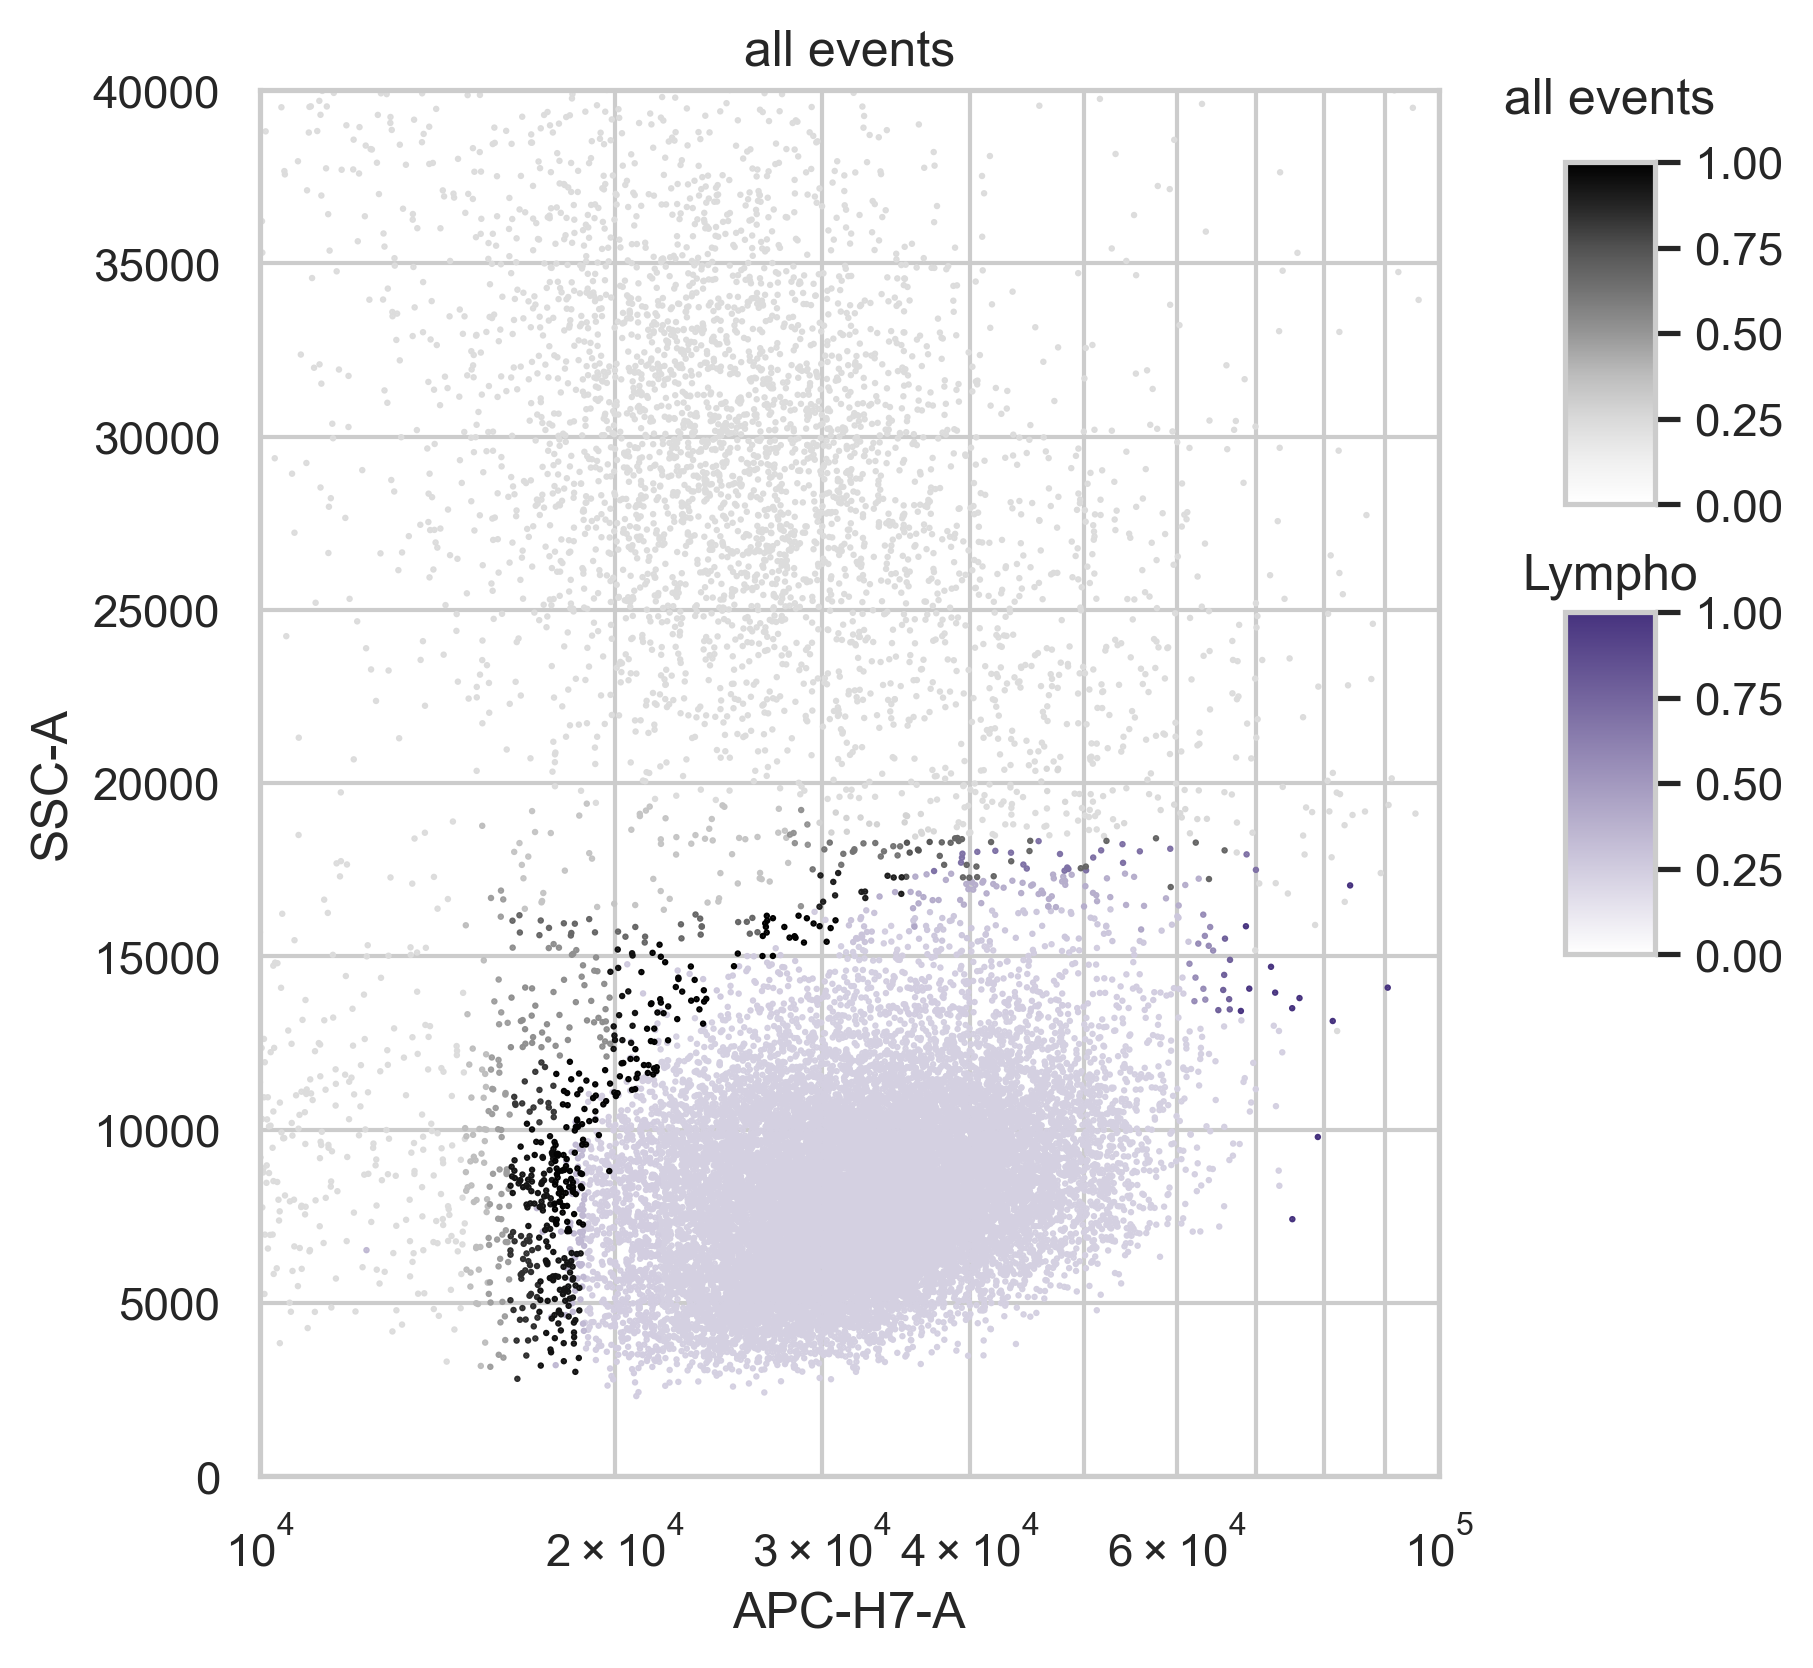

In [56]:
plot_uncertainty_gating(data_all, gating_df, 
                       celltype='Lympho', celltype2='',
                       sample_number=64, show_gates=False, view_window=False,
                       xlim=[10**4, 10**5], ylim=[0, 40000], linthx=1, linthy=150000,
                       hierarchy=hierarchy)

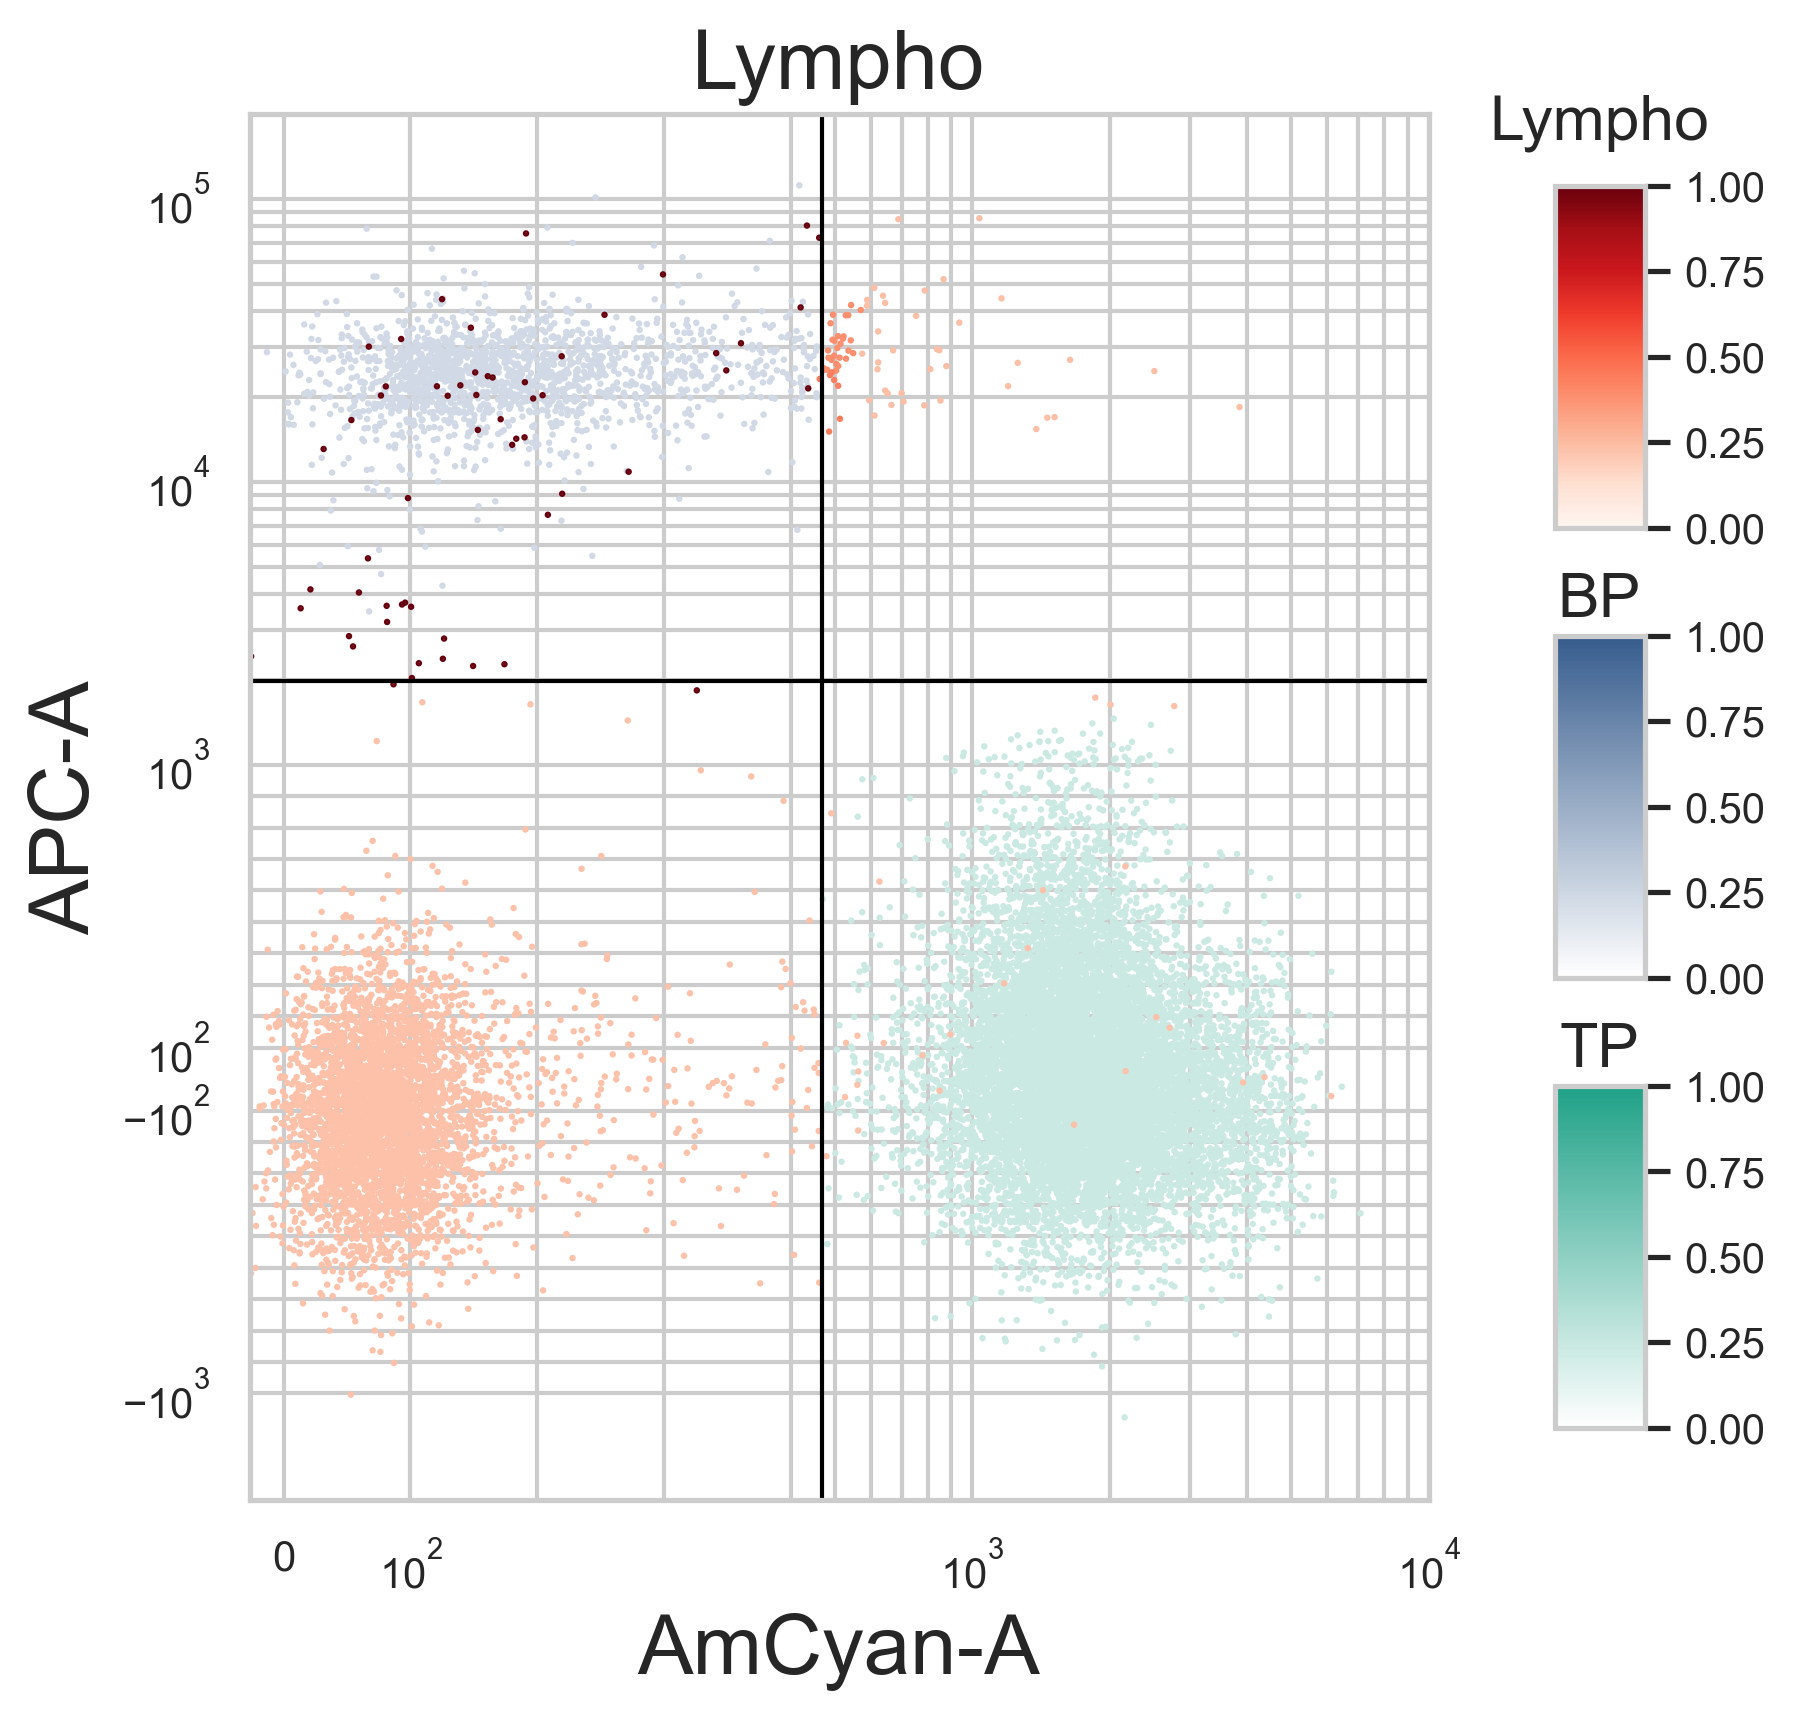

In [57]:
plot_uncertainty_gating(data_all, gating_df, 
                       celltype='BP', celltype2='TP',
                       sample_number=56, show_gates=True, view_window=False,
                       xlim=[-27, 10**4], ylim=[-2374, 2*10**5], linthx=400, linthy=1000,
                       hierarchy=hierarchy)

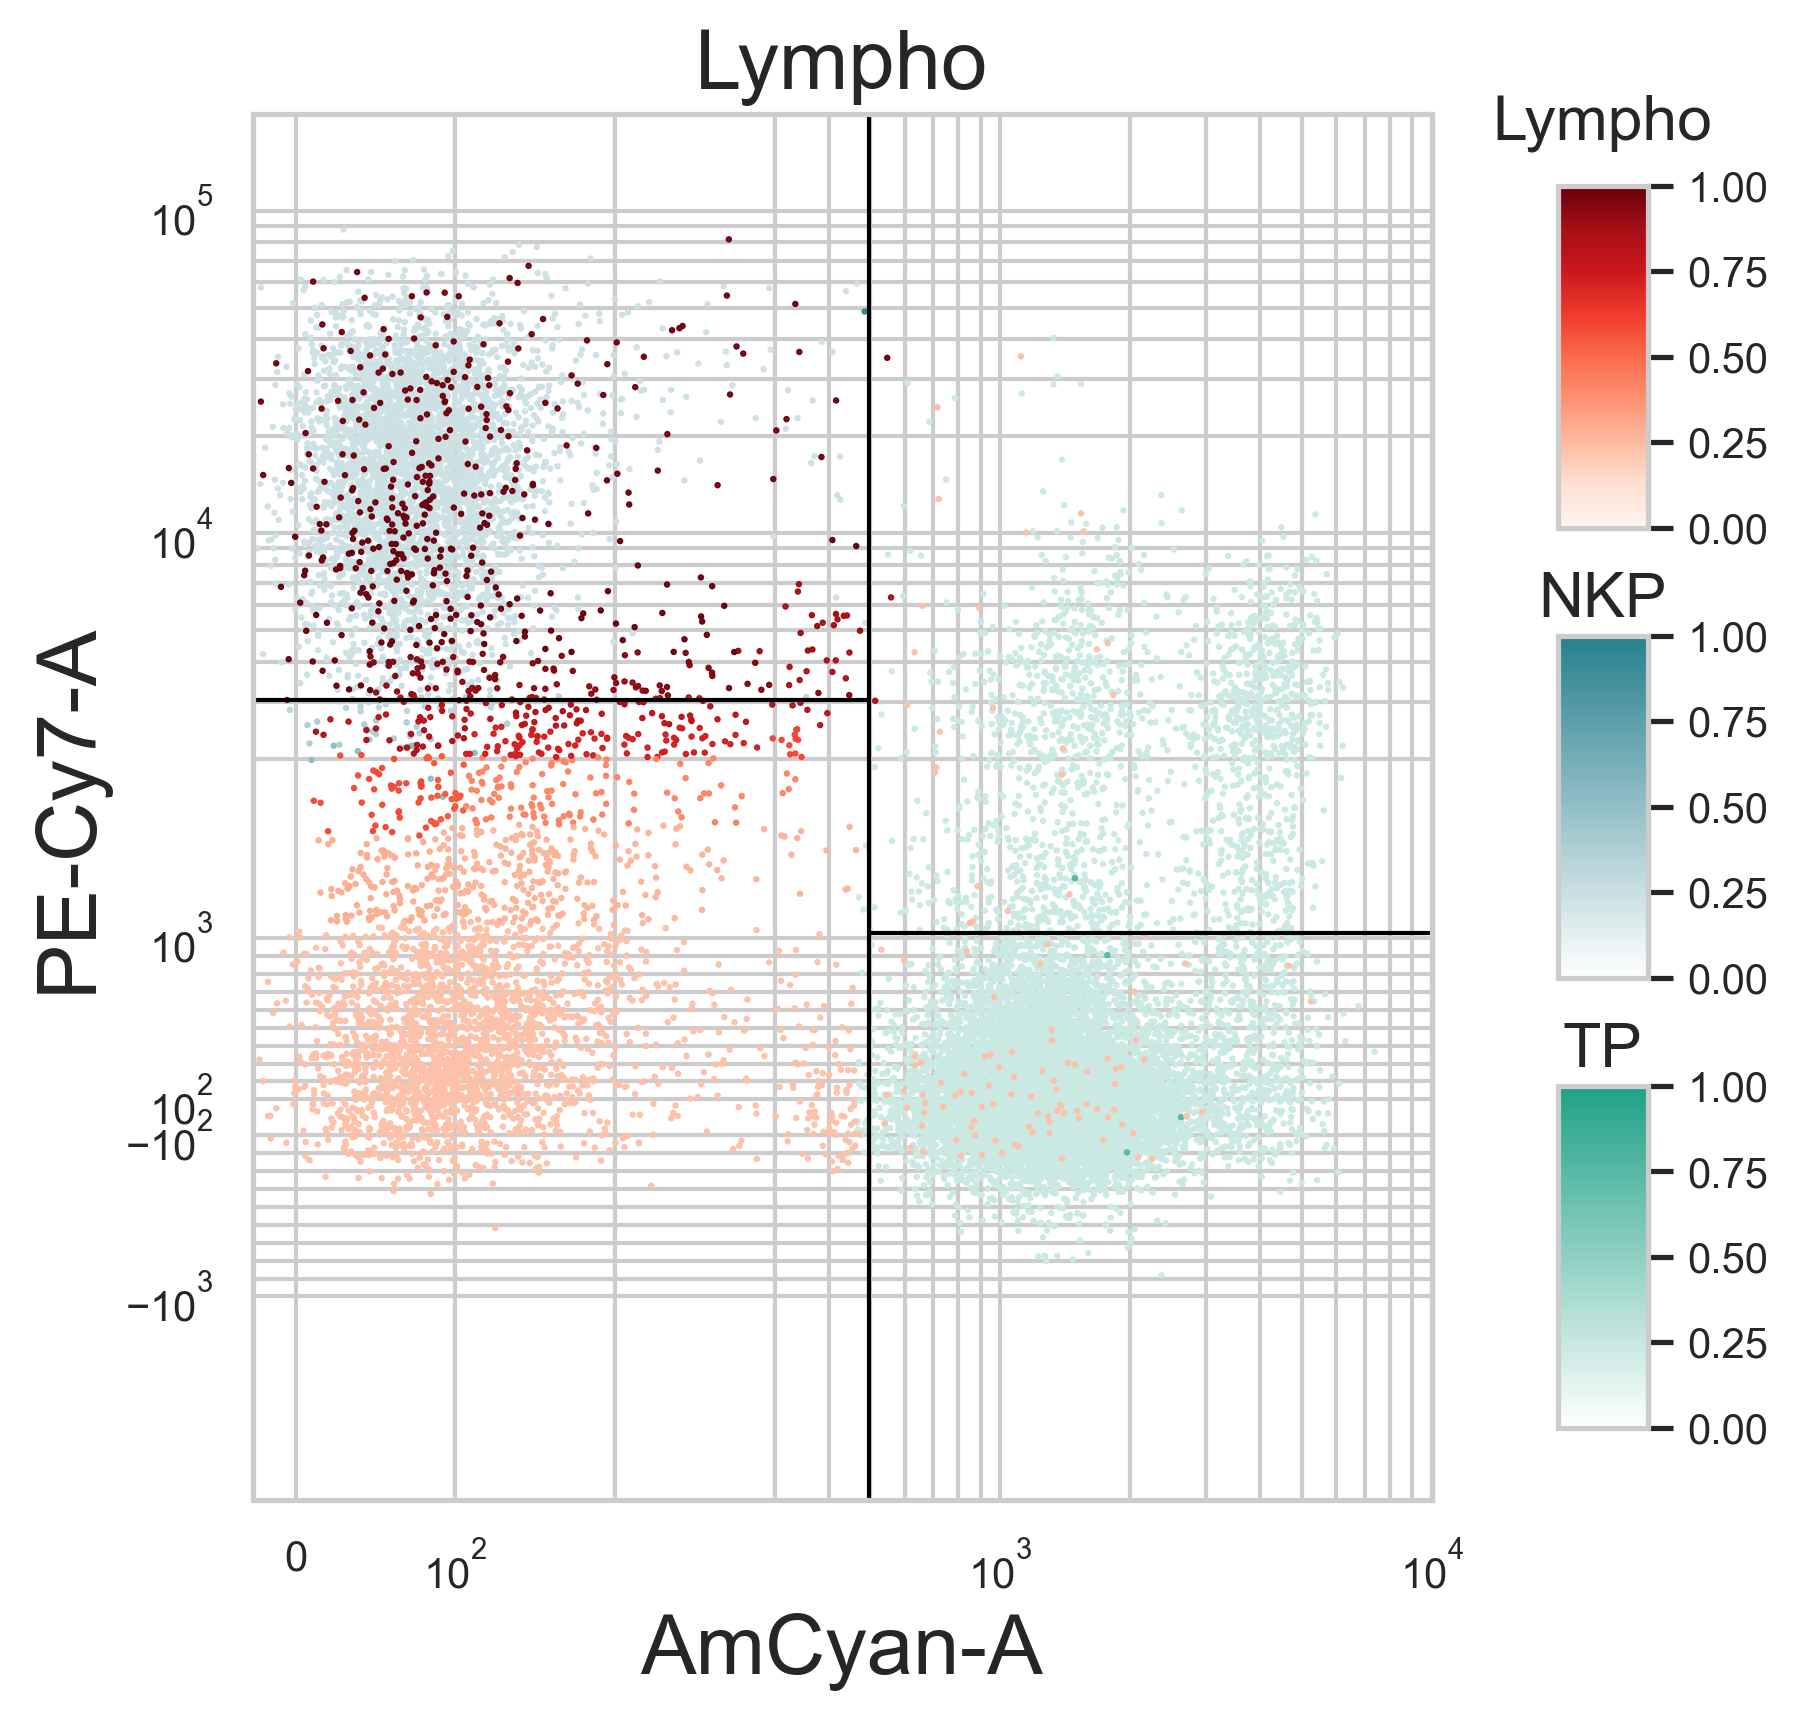

In [58]:
plot_uncertainty_gating(data_all, gating_df, 
                       celltype='NKP', celltype2='TP',
                       sample_number=64, show_gates=True, view_window=False,
                       xlim=[-27, 10**4], ylim=[-2374, 2*10**5], linthx=300, linthy=2000,
                       hierarchy=hierarchy)

**Conclusion**<br>	
Dependable uncertainty estimates on model outcomes are provided.<br>
Dependable uncertainty estimates for events are higher in regions of low density and gate boundaries.<br>
The model informs the user about the quality of prediction results by providing dependable uncertainty estimates within the gating plots.
